In [47]:
import h5py
import gzip
from Bio import SeqIO
import os
from mimetypes import guess_type
from functools import partial
import time
import json
import numpy as np
from refGenome import refGenome_h5
import seaborn as sb

import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from Dataset import SubIntervalDataset
import pandas as pd
from io import StringIO
import cv2

from utils import *

In [48]:
df = pd.read_csv('input.txt', sep='\t')
df['seq_len'] =  df['end'] - df['start']
df['seq_midpoint'] = df['start'] + ((df['end'] - df['start'])//2)

#df['chrom'] = df['chrom'].apply(lambda x: f"{x[:3]}_{x[3:]}")
df.columns

Index(['chrom', 'start', 'end', 'AA1_strength', 'AA2_strength', 'AB1_strength',
       'AB2_strength', 'AC_strength', 'AA1_hotspots', 'AA2_hotspots',
       'AB1_hotspots', 'AB2_hotspots', 'AC_hotspots', 'AA_hotspots',
       'AB_hotspots', 'A_hotspots_intersect', 'A_hotspots_union',
       'A_hotspots_in_AC', 'C_hotspots', 'AA1_down', 'AA1_up', 'AA2_down',
       'AA2_up', 'AB1_down', 'AB1_up', 'at_LCR',
       'Stronger_than_Berg_et_al_Hotspots', 'Unnamed: 27', 'seq_len',
       'seq_midpoint'],
      dtype='object')

In [49]:
outputs = ['AA1_hotspots']

seq_lens  = [100]
chroms_to_use = list(range(16,23))

negative_sampling_intervals=[(1000,5000), (5000,10000), (10000, 20000), (20000,100000)]

random_seed=123

binarize_output = True

grch37_ds = refGenome_h5('/lustre06/project/6065672/otastet1/ref/test_chipseq/genome_test2.h5')
chroms_lens_dict = grch37_ds.metadata['chr_lengths']

chr_16
chr_17
chr_18
chr_19
chr_20
chr_21
chr_22
Object Metadata:
{'encoding_dict': {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4, 'M': 4, 'R': 4}, 'available_chromosomes': ['16', '17', '18', '19', '20', '21', '22'], 'chr_lengths': {'chr_16': 90354753, 'chr_17': 81195210, 'chr_18': 78077248, 'chr_19': 59128983, 'chr_20': 63025520, 'chr_21': 48129895, 'chr_22': 51304566}, 'time created': 1672930838.6544235, 'num_2_base_dict': {0: 'A', 1: 'C', 2: 'T', 3: 'G', 4: 'R'}, 'num_reverse_compliment_dict': {0: 2, 2: 0, 1: 3, 3: 1, 4: 4}}


In [50]:
df['chrom'] = df['chrom'].str.replace('chr','chr_')

In [52]:
df = df.loc[df['chrom'].isin(list(chroms_lens_dict.keys()))]

In [55]:
for output in outputs:
    for seq_len in seq_lens:
        
        # If it's a multioutput dataset
        if isinstance(output, list):
            output_name = output
            
            cols = ['chrom', 'start', 'end']
            cols += output_name
            cols += ['seq_len', 'seq_midpoint']
            
            masks = [df[c] == 1 for c in output]
            masks = np.array(masks).T
            masks = masks.any(axis=1)
            
            df_output = df.loc[masks, cols].copy().reset_index(drop=True)
            
            meta_cols = ['chrom', 'start', 'end', 'seq_len', 'seq_midpoint'] + output_name
            outs_name = ".".join(output)
            output_fname = f"datasets/test2023/{outs_name}_seqlen={seq_len}_multnegs"
            
        else:
            
            output_name = [output]
            cols = ['chrom', 'start', 'end', f"{output}", 'seq_len', 'seq_midpoint']  
            
            df_output = df.loc[df[output] == 1, cols].copy().reset_index(drop=True)
            
            meta_cols = ['chrom', 'start', 'end', 'seq_len', 'seq_midpoint', f"{output}"]

            output_fname = f"datasets/test2023/test/{output}_seqlen={seq_len}_multnegs"
        
        print(f"OUTPUT DATAFRAME AFTER FILTERING {output}")
        print(df_output)
        print(output_name, seq_len)
        print("\n\n\n")
        
        create_h5_dataset_by_chromosome(df=df_output,
                                        output_fname=output_fname,
                                        grch_obj=grch37_ds,
                                        chroms_lens_dict=chroms_lens_dict,
                                        seq_len=seq_len,
                                        negative_sampling_intervals=negative_sampling_intervals,
                                        chr_col='chrom',
                                        start_col='start',
                                        end_col='end',
                                        seq_midpoint_col='seq_midpoint',
                                        output_cols_list=output_name, #always pass a list, even for a single out

                                        binarize_output=binarize_output,

                                        pos_suffix='pos',
                                        neg_suffix='neg',

                                        seq_suffix='seq',
                                        metadata_suffix='meta',
                                        output_suffix='out',
                                        
                                        random_seed=random_seed,

                                        test_set_size=0.1,
                                        test_set_sampling='uniform')
        
        print("*"*80)
        print("*"*80)
        print("*"*80)

OUTPUT DATAFRAME AFTER FILTERING AA1_hotspots
       chrom     start       end  AA1_hotspots  seq_len  seq_midpoint
0     chr_16     65848     68149             1     2301         66998
1     chr_16     93365     94611             1     1246         93988
2     chr_16    114786    116362             1     1576        115574
3     chr_16    129602    133731             1     4129        131666
4     chr_16    138725    140451             1     1726        139588
...      ...       ...       ...           ...      ...           ...
4108  chr_22  51151831  51155574             1     3743      51153702
4109  chr_22  51173142  51174862             1     1720      51174002
4110  chr_22  51176236  51177389             1     1153      51176812
4111  chr_22  51203917  51205472             1     1555      51204694
4112  chr_22  51205924  51207509             1     1585      51206716

[4113 rows x 6 columns]
['AA1_hotspots'] 100




Creating dataset for chromosome chr_16:
	Constructing Positive D

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 724 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        66948     67048         66998           65848         68149   
1        93938     94038         93988           93365         94611   
2       115524    115624        115574          114786        116362   
3       131616    131716        131666          129602        133731   
4       139538    139638        139588          138725        140451   
..         ...       ...           ...             ...           ...   
719   90070186  90070286      90070236        90069139      90071333   
720   90080738  90080838      90080788        90079853      90081724   
721   90108264  90108364      90108314        90106696      90109933   
722   90123927  90124027      90123977        90122712      90125242   
723   90258498  90258598      90258548        90257925      90259171  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1350 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1326, 6) is 183.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1321 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1246, 6) is 172.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1241 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (525, 6) is 72.51% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 524 examples
	Splitting train\test, data length = 724
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_seq, shape=(724, 100)
	Splitting train\test, data length = 724
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_out, shape=(724, 1)
	Splitting train\test, data length = 724
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_meta, shape=(724, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         5656      5756          5706            5091          6322   
1        26157     26257         26207           24604         27811   
2        30618     30718         30668           29539         31798   
3        36163     36263         36213           35444         36983   
4        51146     51246         51196           50029         52363   
..         ...       ...           ...             ...           ...   
636   81048559  81048659      81048609        81047638      81049580   
637   81070036  81070136      81070086        81068478      81071694   
638   81085229  81085329      81085279        81084668      81085891   
639   81108953  81109053      81109003        81108592      81109415   
640   81125033  811251

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1196 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1175, 6) is 183.31% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1175 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1074, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1074 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (482, 6) is 75.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 479 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_seq, shape=(641, 100)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_meta, shape=(641, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 738 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        99508     99608         99558           98565        100551   
1       125433    125533        125483          124912        126054   
2       152433    152533        152483          151650        153316   
3       173271    173371        173321          172762        173881   
4       249340    249440        249390          248403        250377   
..         ...       ...           ...             ...           ...   
733   77929315  77929415      77929365        77928652      77930078   
734   77959451  77959551      77959501        77958959      77960044   
735   77962285  77962385      77962335        77961621      77963050   
736   77968538  77968638      77968588        77968005      77969171   
737   77974454  77974554      77974504 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1374 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1354, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1352 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1256, 6) is 170.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (563, 6) is 76.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 558 examples
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_seq, shape=(738, 100)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_out, shape=(738, 1)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_meta, shape=(738, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 533 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        78752     78852         78802           78199         79405   
1        80898     80998         80948           79852         82045   
2       131917    132017        131967          131358        132577   
3       171278    171378        171328          170566        172090   
4       176739    176839        176789          176168        177410   
..         ...       ...           ...             ...           ...   
528   58604623  58604723      58604673        58603846      58605500   
529   58745663  58745763      58745713        58744907      58746520   
530   58806898  58806998      58806948        58806143      58807754   
531   58911652  58911752      58911702        58911034      58912370   
532   59028334  59028434      59028384

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (992, 6) is 186.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 989 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (924, 6) is 173.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 922 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (377, 6) is 70.73% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 376 examples
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_seq, shape=(533, 100)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_out, shape=(533, 1)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_meta, shape=(533, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 499 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        69094     69194         69144           67982         70307   
1        82255     82355         82305           81386         83225   
2       134108    134208        134158          133641        134675   
3       247373    247473        247423          246512        248334   
4       254717    254817        254767          254136        255399   
..         ...       ...           ...             ...           ...   
494   62826112  62826212      62826162        62825431      62826893   
495   62856629  62856729      62856679        62855736      62857622   
496   62879557  62879657      62879607        62878978      62880236   
497   62884556  62884656      62884606        62883896      62885317   
498   62948054  62948154      62948104        62947560      62948648   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 928 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (918, 6) is 183.97% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 915 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (852, 6) is 170.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 849 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (360, 6) is 72.14% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 356 examples
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_seq, shape=(499, 100)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_out, shape=(499, 1)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_meta, shape=(499, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 500 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9483967   9484067       9484017         9482858       9485177   
1      9826638   9826738       9826688         9825203       9828173   
2     14398693  14398793      14398743        14398084      14399402   
3     14596636  14596736      14596686        14595465      14597907   
4     14600181  14600281      14600231        14599322      14601140   
..         ...       ...           ...             ...           ...   
495   47970498  47970598      47970548        47969295      47971802   
496   47974539  47974639      47974589        47974108      47975071   
497   48023319  48023419      48023369        48022698      48024041   
498   48054895  48054995      48054945        48054295      48055596   
499   48094060  48094160      48094110        48092857      48095364   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (918, 6) is 183.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 914 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (902, 6) is 180.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 898 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (808, 6) is 161.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 805 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (306, 6) is 61.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 302 examples
	Splitting train\test, data length = 500
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_seq, shape=(500, 100)
	Splitting train\test, data length = 500
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_out, shape=(500, 1)
	Splitting train\test, data length = 500
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_meta, shape=(500, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 478 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17958465  17958565      17958515        17957873      17959157   
1     17985773  17985873      17985823        17985006      17986641   
2     17989893  17989993      17989943        17989014      17990873   
3     18053934  18054034      18053984        18053216      18054752   
4     18057696  18057796      18057746        18056691      18058802   
..         ...       ...           ...             ...           ...   
473   51153652  51153752      51153702        51151831      51155574   
474   51173952  51174052      51174002        51173142      51174862   
475   51176762  51176862      51176812        51176236      51177389   
476   51204644  51204744      51204694        51203917      51205472   
477   51206666  51206766      51206716 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (884, 6) is 184.94% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 882 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (866, 6) is 181.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 863 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (798, 6) is 166.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 795 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (271, 6) is 56.69% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/build_dataset/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 267 examples
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_seq, shape=(478, 100)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_out, shape=(478, 1)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_meta, shape=(478, 15)
	Splitting train\test, data leng

In [10]:
individuals = ['AA','AA1', 'AA2', 'AB1', 'AC']
outputs = ['AA1_hotspots','AA2_hotspots','AB1_hotspots','AC_hotspots','AA_hotspots']

seq_lens  = [100,200,400,600]
chroms_to_use = list(range(1,23)) + ['X','Y','MT']

negative_sampling_intervals=[(1000,5000), (5000,10000), (10000, 20000), (20000,100000)]

random_seed=123

binarize_output = True

grch37_ds = refGenome_h5('/lustre06/project/6065672/otastet1/ref/h5_genome/grch37_h5_all.h5')
chroms_lens_dict = grch37_ds.metadata['chr_lengths']

chr_1
chr_10
chr_11
chr_12
chr_13
chr_14
chr_15
chr_16
chr_17
chr_18
chr_19
chr_2
chr_20
chr_21
chr_22
chr_3
chr_4
chr_5
chr_6
chr_7
chr_8
chr_9
chr_MT
chr_X
chr_Y
Object Metadata:
{'encoding_dict': {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4, 'M': 5, 'R': 6}, 'available_chromosomes': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT'], 'chr_lengths': {'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, '6': 171115067, '7': 159138663, '8': 146364022, '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540, '15': 102531392, '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520, '21': 48129895, '22': 51304566, 'X': 155270560, 'Y': 59373566, 'MT': 16569}, 'time created': 1665661674.6308951, 'num_2_base_dict': {0: 'A', 1: 'C', 2: 'T', 3: 'G', 4: 'N', 5: 'M', 6: 'R'}, 'num_reverse_compliment_dict': {0: 2, 2: 0, 1

In [56]:
d1 = h5py.File('datasets/test2023/test/AA1_hotspots_seqlen=100_multnegs.h5','r')

In [62]:
d1['train']

<bound method MappingHDF5.items of <HDF5 group "/train" (77 members)>>

In [64]:
dp_seq = d1['train']['chr_16_pos_seq']
dp_meta = d1['train']['chr_16_pos_meta']

In [65]:
dp_seq.shape[0]

651

In [11]:
grch37_ds.convert_num_to_bases(dp_seq[0])
str(dp_meta[0][0:2])

'[36728 36928]'

In [66]:
def h5_to_fasta(fname,outfile):
    out = open(outfile, "a")
    d1 = h5py.File(fname,'r')
    
    dp_seq = d1['train']['chr_1_pos_seq']
    dp_meta = d1['train']['chr_1_pos_meta']
    for i in range(0,dp_seq.shape[0]):
        start = str(dp_meta[i][0])
        end = str(dp_meta[i][1])
        chrom = 'chr1'
        header = f">{chrom}:{start}-{end}\n"
        out.write(header)
        out.write(''.join(grch37_ds.convert_num_to_bases(dp_seq[i]))+'\n')

In [67]:
h5_to_fasta('datasets/test2023/test/AA1_hotspots_seqlen=100_multnegs.h5','datasets/test2023/test/AA1_hotspots_seqlen=100_multnegs.fa')

KeyError: "Unable to open object (object 'chr_1_pos_seq' doesn't exist)"

In [49]:
dat = eu.dl.read_fasta('out.fa',rev_comp=True)

Reverse complementing sequences:   0%|          | 0/1926 [00:00<?, ?it/s]

In [53]:
dat

SeqData object with = 1926 seqs
seqs = (1926,)
names = (1926,)
rev_seqs = (1926,)
ohe_seqs = None
ohe_rev_seqs = None
pos_annot: None
seqsm: None
uns: None

In [30]:
tmp = dp_meta[0]

In [ ]:
tmp.

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()   

In [7]:
seqs_p = []
for idx, seq in enumerate(dp):
    seqs_p.append((1,seq))
    
seqs_n = []
for idx, seq in enumerate(dn):
    seqs_n.append((0,seq))

In [72]:
random.shuffle(seq_df)

In [74]:
with open('dataset.txt','w') as newfile:
    count = 0 
    for i in seq_df:
        count+=1
        newfile.writelines(f'>seq_{count}\n')
        newfile.writelines(f"{''.join(grch37_ds.convert_num_to_bases(i[1]))}\n")
        newfile.writelines(f'{i[0]}\n')

In [60]:
for x,y in enumerate(seq_df):
    print(y[0])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [8]:
seq_df_p = pd.DataFrame(np.array(seqs_p))
seq_df_p['type'] = 'positif'

/tmp/ipykernel_1917253/854650384.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_df_p = pd.DataFrame(np.array(seqs_p))


In [9]:
seq_df_n = pd.DataFrame(np.array(seqs_n))
seq_df_n['type'] = 'negatif'

/tmp/ipykernel_1917253/3487262617.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_df_n = pd.DataFrame(np.array(seqs_n))


In [10]:
seq_df = pd.concat([seq_df_p,seq_df_n])

In [11]:
ohe = grch37_ds.one_hot_encode(seq_df.drop('type',axis=1))

NameError: name 'grch37_ds' is not defined

In [20]:
X = seq_df.drop('type',axis=1)

Calculating PHATE...
  Running PHATE on 1027 observations and 800 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.41 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.54 seconds.
Calculated PHATE in 1.23 seconds.


/var/folders/qy/m3n_w10n31q06s6_0fk1_j800000gn/T/ipykernel_82371/1198280288.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(data_phate, c=seq_df['type'])
/Users/otastet/.local/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: >

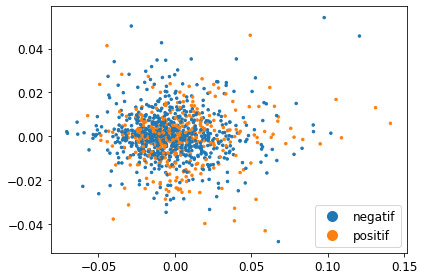

In [29]:
phate_op = phate.PHATE(t=10)
data_phate = phate_op.fit_transform(X)
phate.plot.scatter2d(data_phate, c=seq_df['type'])

In [ ]:
d1['train']['chr_21_neg_seq'].neg_df.to_csv('negative_examples.bed',sep='\t',header=False,index=False)
intervals.pos_df.to_csv('positive_examples.bed',sep='\t',header=False,index=False)

In [53]:
!make_tracks_file --trackFiles negative_examples.bed positive_examples.bed -o tracks.ini 
!pyGenomeTracks --tracks tracks.ini --region chr_21:9436792-15596465 --outFileName nice_image.png

Adding bed file: negative_examples.bed
Adding bed file: positive_examples.bed
INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [negative_examples]
100%|████████████████████████████████████████| 20/20 [00:00<00:00, 32780.81it/s]
INFO:pygenometracks.tracksClass:initialize 4. [positive_examples]
*Warning, invalid strand valuefound 9437387 for line #chr_21	9436792	9437983	36	1191	9437387	9435637	9439137
:
1
 Setting strand to '.'
  0%|                                                    | 0/19 [00:00<?, ?it/s]*Warning, invalid strand valuefound 9437387 for line #chr_21	9436792	9437983	36	1191	9437387	9435637	9439137
:
2
 Setting strand to '.'
*Warning, invalid strand valuefound 9484017 for line #chr_21	9482858	9485177	376	2319	9484017	9482267	9485767
:
3
 Setting strand to '.'
*Warning, invalid strand valuefound 9826688 for line #chr_21	9825203	9828173	156	2970	9826688	9824938	9828438


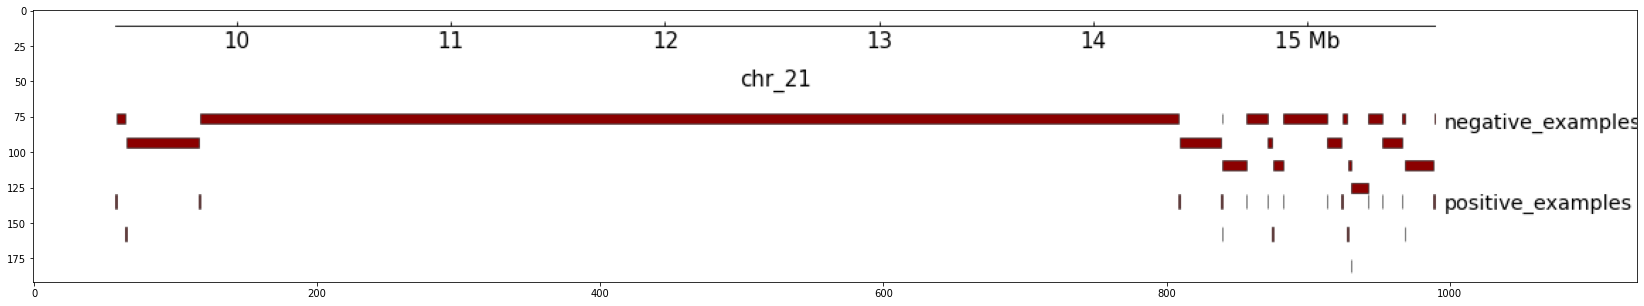

In [54]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (50, 5) # (w, h)

im = cv2.imread('nice_image.png')

plt.imshow(im)
plt.show()